In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')


In [68]:
df = pd.read_csv('Rainfall.csv')
df.columns = df.columns.str.strip()
df.dropna(inplace=True)

In [69]:
df['season'] = pd.cut(df['day'], bins=[0, 90, 180, 270, 366],
                      labels=['Winter', 'Summer', 'Monsoon', 'Post-Monsoon'])
df['season'] = df['season'].astype(str)
le = LabelEncoder()
df['season_encoded'] = le.fit_transform(df['season'])
df['rain_class'] = df['rainfall'].str.strip().map({'no': 0, 'yes': 1})
df['prev_rain'] = df['rain_class'].shift(1)
df.dropna(inplace=True)

In [70]:
df['humidity_cloud'] = df['humidity'] * df['cloud']
df['dew_temp_diff'] = df['dewpoint'] - df['temparature']
df['sun_wind'] = df['sunshine'] * df['windspeed']
df['temp_humidity_ratio'] = df['temparature'] / (df['humidity'] + 1)
df['pressure_temp_diff'] = df['pressure'] - df['temparature']


In [71]:
features = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
            'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed',
            'season_encoded', 'prev_rain', 'humidity_cloud', 'dew_temp_diff',
            'sun_wind', 'temp_humidity_ratio', 'pressure_temp_diff']
X = df[features]
y = df['rain_class']

In [72]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)

# Accuracy
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

# Predict for a new sample (example values, change as needed)
sample = pd.DataFrame([{
    'pressure': 1012, 'maxtemp': 32, 'temparature': 30, 'mintemp': 28,
    'dewpoint': 25, 'humidity': 85, 'cloud': 6, 'sunshine': 4,
    'winddirection': 180, 'windspeed': 12, 'season_encoded': 2,
    'prev_rain': 1, 'humidity_cloud': 85 * 6, 'dew_temp_diff': 25 - 30,
    'sun_wind': 4 * 12, 'temp_humidity_ratio': 30 / (85 + 1),
    'pressure_temp_diff': 1012 - 30
}])

# Predict and interpret
prediction = clf.predict(sample)[0]
print("Prediction:", "Yes, it will rain." if prediction == 1 else "No, it will not rain.")


Accuracy: 78.08%
Prediction: No, it will not rain.


In [73]:
models = {
    'Logistic Regression': LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, eval_metric='logloss', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
}

accuracies = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred) * 100
    accuracies[name] = acc
    print(f"{name} Accuracy: {acc:.2f}%")


Logistic Regression Accuracy: 80.82%
Random Forest Accuracy: 79.45%
XGBoost Accuracy: 76.71%
Gradient Boosting Accuracy: 72.60%


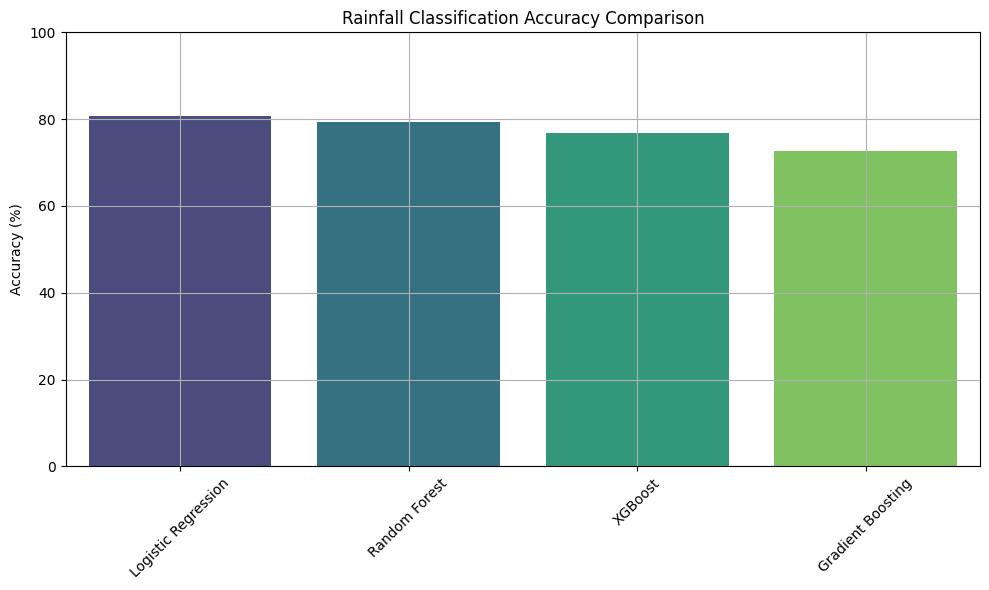

In [74]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette='viridis')
plt.ylabel('Accuracy (%)')
plt.title('Rainfall Classification Accuracy Comparison')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
